<a href="https://colab.research.google.com/github/Jen-Ocana/Fisica-Computacional-1/blob/master/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas.util.testing as tm

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf

#Suprimir mensajes de alertas de cambios futuros
import warnings 
warnings.simplefilter(action='ignore',category=FutureWarning)

%matplotlib inline 

In [95]:
#En una celda concentramos todas las operaciones
#Sobre las transformaciones del dataframe original
# Preparando el dataframe df_meteo


url='https://raw.githubusercontent.com/Jen-Ocana/Fisica-Computacional-1/master/Actividad%203/8352.txt'
my_cols=['Fecha','Precip','Evap','Tmax','Tmin']
df_orig=pd.read_csv(url,names=my_cols,encoding='cp1251',sep='\s+',
                    header=None,skiprows=19,skipfooter=1,engine='python')
#definimos un data frame con los nombres de las columnas, el archivo tiene codigos ACII extendido que es el español, asi que se lo indicamos con encoding
#Se brincara los primeros 19 reglones que no tienen info y le ultimo sin encabezado
df_work0=df_orig.copy()
#Cambiamos los espacios en blanco por 'nulo' 
str_Nulo='Nulo'
df_work1=df_work0.replace(to_replace=str_Nulo,value='',regex=True)
#Convertimos los valores de las variables ambientales a num. flotantes
cols_list=['Precip','Evap','Tmax','Tmin']
for cols in cols_list:
  df_work1[cols]=pd.to_numeric(df_work1[cols],errors='coerce')
#la copia por si es necesario
df_work2=df_work1.copy()
#El primer dato es el dia
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'],dayfirst=True).copy()
#Dos columnas adicionales, una de año y otra de mes
#Usamos la funcion .dt.year y .dt.month para extraerlos de la fecha
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año']=df_work2['Fecha'].dt.year
df_work2['Mes']=df_work2['Fecha'].dt.strftime('%b')
##Para esta actividad definimos un nuevo dataframe para el analisis
#Para nuevo punto de partida
df_meteo = df_work2.copy()

##ELIMINEMOS LA COLUMNA DE MES NUMERICO
df_meteo.drop('Mes',axis=1,inplace=True)
df_meteo['Mes']=df_meteo['Fecha'].dt.strftime('%b')

df_meteo_ts = df_meteo.copy()
df_meteo_ts = df_meteo_ts.set_index('Fecha')

df_meteo_ts.info()

##Seleccionamos un conjunto de año de los 27 años crando las colecciones de datos
df_90 = df_meteo_ts[(df_meteo_ts['Año']>=1980)&(df_meteo_ts['Año']<=1990)]
df_00 = df_meteo_ts[(df_meteo_ts['Año']>=1990)&(df_meteo_ts['Año']<=2020)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7907 entries, 1983-07-01 to 2007-11-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  7783 non-null   float64
 1   Evap    0 non-null      float64
 2   Tmax    7815 non-null   float64
 3   Tmin    7819 non-null   float64
 4   Año     7907 non-null   int64  
 5   Mes     7907 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 432.4+ KB


Definimos una funcion para probar la Estacionaridad de una serie de tiempo usando la prueba aumentada de dickey-fuller(ADF)


In [96]:
#Funcion para probar la estacionaridad de una serie de tiempo

def test_stationarity (df_ts):

  #determinar la estadistica de promedios moviles
  rolmean = df_ts.rolling(window=365,center=True,min_periods=1).mean()
  rolstd = df_ts.rolling(window=365,center=True,min_periods=1).std()

  #Define el tamaño de la figura
  plt.rcParams["figure.figsize"]=(12,6)

  #Graficar la estadistica de promedios moviles
  plt.plot(df_ts,color="blue",label='Original')
  plt.plot(rolmean,color="red",label='Rolling mean')
  plt.plot(rolstd,color='black',label='Rolling Std Deviation')

  plt.legend(loc='best')
  plt.title('Promedio movil y desviacion estandar')
  plt.grid()
  plt.show()

  #Realizando la prubea aumentada de dickey fuller
  print('Los resultados de la prueba de Dickey-Fuller: ')
  dftest = adfuller(df_ts,autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test Stadistic','p-Value',
                                          '#Lags used',
                                          'Number of observations used'])
  
  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key]=value
  print(dfoutput)

Definimos la serie de tiempo a probar...

In [97]:
#Creamos la primer serie de tiempo a analizar
#Haciendo una copia de la epoca de 1990 a 2007 que tenemos
#O el periodo que se desee. Podemos regresar a este punto 
#La veces que se requiera definir 

#Fechas de inicio y fin, para filtrar la informacion 
start, end ='1987-06','1991-01'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()
ts_90.tail()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1990-12-27,40.0,NaN,33.0,13.0,1990,Dec
1990-12-28,52.0,NaN,33.0,12.0,1990,Dec
1990-12-29,0.0,NaN,32.0,13.0,1990,Dec
1990-12-30,0.0,NaN,23.0,11.0,1990,Dec
1990-12-31,0.0,NaN,24.0,-4.0,1990,Dec


#Temperatura maxima


In [98]:
#Definimos la serie de tiempo con Tmax que vamos a estudiar
#le damos un nombre generico 
ts_test = ts_90['Tmax'].copy()


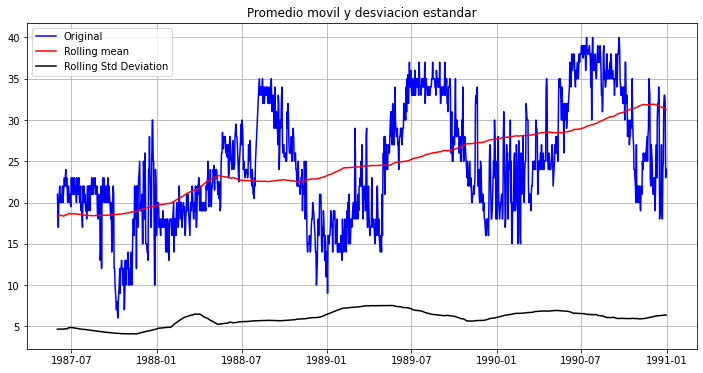

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                   -2.425941
p-Value                           0.134548
#Lags used                       11.000000
Number of observations used    1291.000000
Critical Value(1%)               -3.435425
Critical Value(5%)               -2.863781
Critical Value(10%)              -2.567963
dtype: float64


In [99]:
#Realizamos la prueba de estacionaridad de Tmax
test_stationarity(ts_test)

Vemos que no es estacionaria

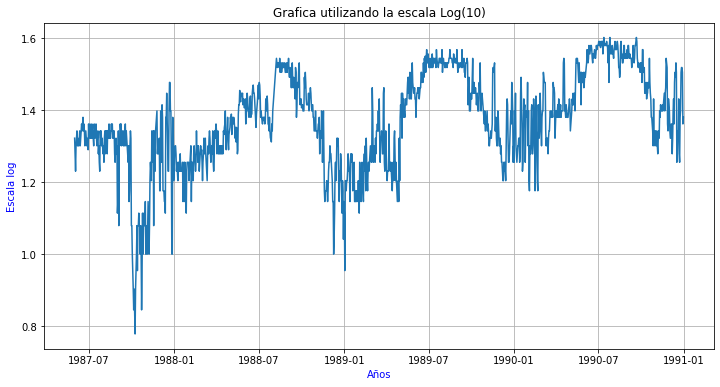

In [100]:
#Funcion logaritmo base 1o y graficamos la escala

ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala log',color='b')
plt.title('Grafica utilizando la escala Log(10)')
plt.grid()
plt.show();


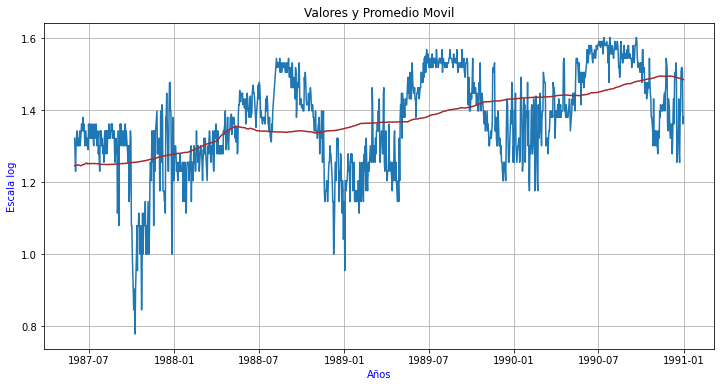

In [101]:
#Calculamos el promedio movil de ts_test_log con ventana de 365 y graficar para ver el constraste
moving_avg = ts_test_log.rolling(365,center=True,min_periods=1).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg,color='brown')
plt.xlabel('Años',color='blue')
plt.ylabel('Escala log',color='b')
plt.title('Valores y Promedio Movil')
plt.grid()
plt.show();

In [102]:
ts_test_log_moving_ave_diff=ts_test - moving_avg
ts_test_log_moving_ave_diff.head()
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1987-06-01    19.754155
1987-06-02    17.754534
1987-06-03    15.754909
1987-06-04    18.754088
1987-06-05    19.753369
Name: Tmax, dtype: float64

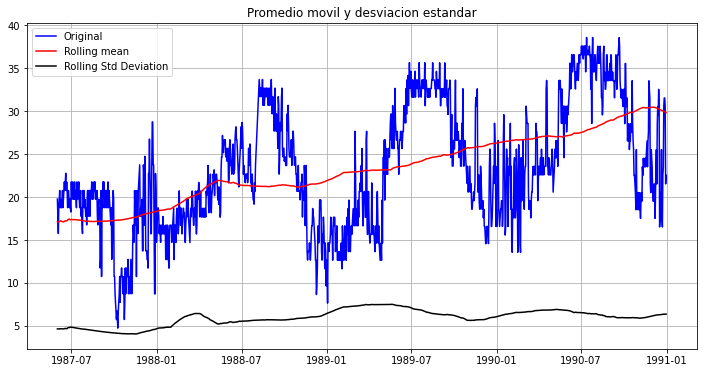

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                   -2.440474
p-Value                           0.130637
#Lags used                       11.000000
Number of observations used    1291.000000
Critical Value(1%)               -3.435425
Critical Value(5%)               -2.863781
Critical Value(10%)              -2.567963
dtype: float64


In [103]:
test_stationarity(ts_test_log_moving_ave_diff)

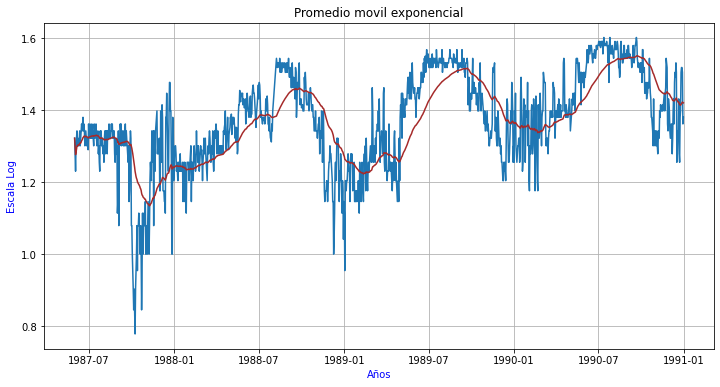

In [104]:
#Repetimos el calculo usando promedios moviles exponenciales

#EL parametro halflife represnta el numero de dias que tienen cierta influencia
#en el promedio, pero su influencia decae exponencialmente 

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg,color='brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio movil exponencial')
plt.grid()
plt.show();

In [105]:
EWM_avg.head()

Fecha
1987-06-01    1.322219
1987-06-02    1.300235
1987-06-03    1.276434
1987-06-04    1.282798
1987-06-05    1.291050
Name: Tmax, dtype: float64

In [106]:
ts_test_log_EWM_avg_diff= ts_test_log - EWM_avg

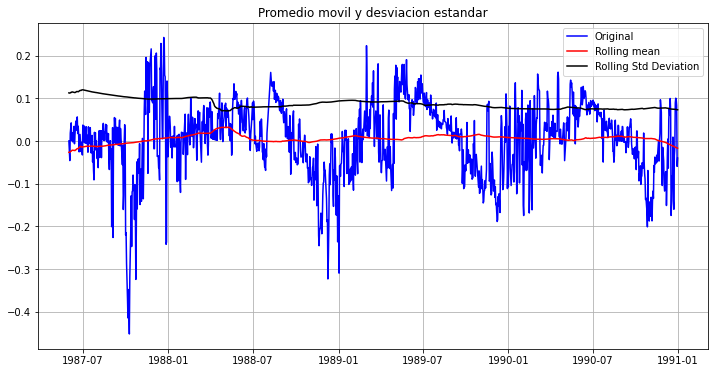

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                   -4.488257
p-Value                           0.000206
#Lags used                       11.000000
Number of observations used    1291.000000
Critical Value(1%)               -3.435425
Critical Value(5%)               -2.863781
Critical Value(10%)              -2.567963
dtype: float64


In [107]:
#Probemos la estacionaridad de la nueva serie de tiempo escalada
#En log y usando EWm
test_stationarity(ts_test_log_EWM_avg_diff)

Hasta aqui hemos eliminado la tendencia pero nos falta trabajar la estacionalidad 


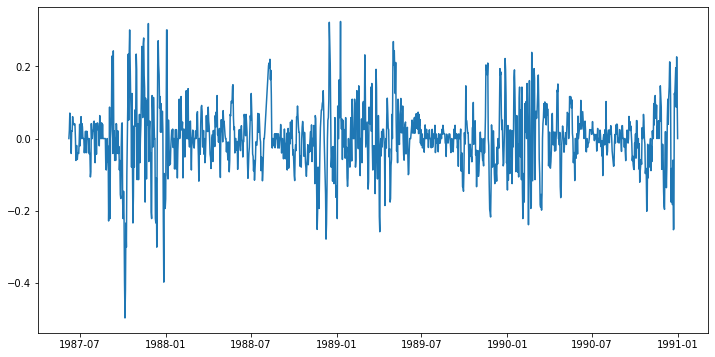

In [108]:
#Utilizamos un metodo llamado diferenciacion discreta 
#Calcular diferencas involucrando un corrimiento 'shift()'
ts_test_log_diff = ts_test_log -ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

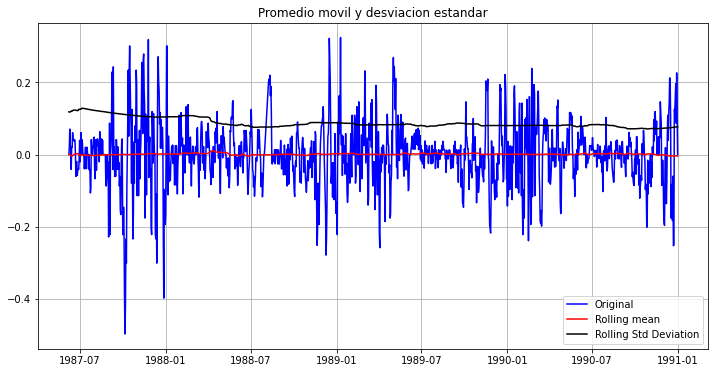

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                -8.387998e+00
p-Value                        2.409052e-13
#Lags used                     2.100000e+01
Number of observations used    1.274000e+03
Critical Value(1%)            -3.435493e+00
Critical Value(5%)            -2.863811e+00
Critical Value(10%)           -2.567979e+00
dtype: float64


In [109]:
#Probamos la estacionaridad 
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [110]:
len(ts_test_log_diff)

1296

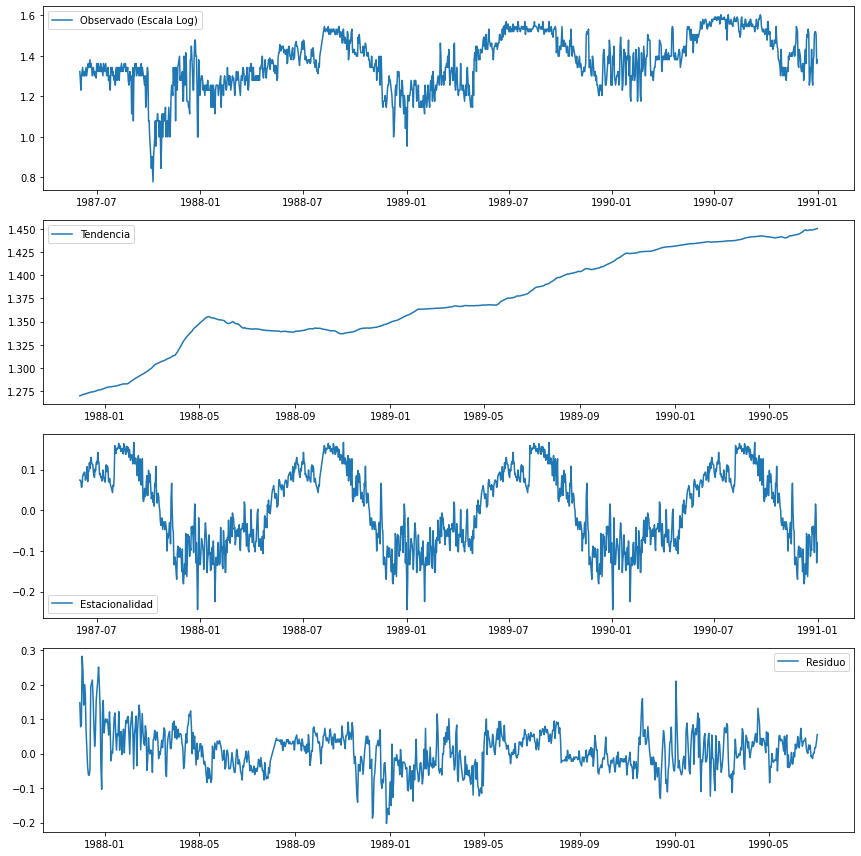

In [111]:
# Método de descomposición usando la biblioteca statsmodels.tsa
#pasoextra_log=np.log10(ts_test_log) 
#pasoextra2_log=np.log10(pasoextra_log)
#pasoextra2_log.dropna(inplace=True)
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(),
                                         model='additive', freq=365)
#decomposition = sm.tsa.seasonal_decompose(pasoextra_log.interpolate(),
 #                                         model='additive', freq=365)

# La función regresa 3 componentes: tendencia,
# estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

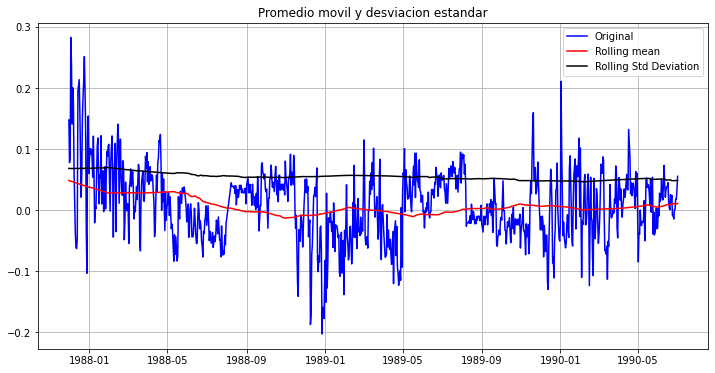

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                  -4.351772
p-Value                          0.000361
#Lags used                      14.000000
Number of observations used    924.000000
Critical Value(1%)              -3.437447
Critical Value(5%)              -2.864673
Critical Value(10%)             -2.568438
dtype: float64


In [112]:

# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo
# es estacionaria o no

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

**Pronostico de Series de Tiempo**
Construiremos un modelo utlizando diferenciacion porque es facil añadir el error, la tendencia y la estacionalidad a las predicciones. 
Utilizaremos el metodo ***ARIMA***


Utilizaremos las propiedades de la Distribucion normal centrada en el promedio y std dev = 1, donde el 95% de los datos caen entre -1.96 y 1.96 



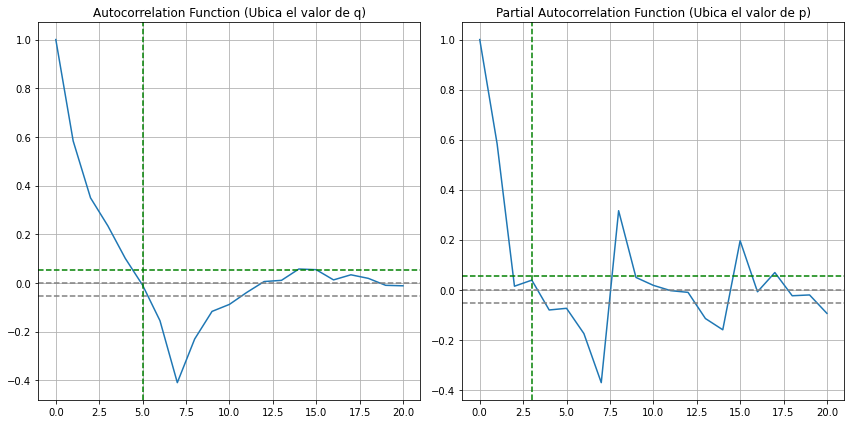

In [113]:
#Aplicando ARIMA

lag_acf = acf(ts_test_log_diff,nlags=20)
lag_pacf = pacf(ts_test_log_diff,nlags=20,method = 'ols')

#Tamaño de graficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=5, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=3, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

p es del Partial autocorrelation function
p cruza en 3 mas cercano que 4, asi que p=3
numeros para la regresion

q es donde cruza autocorrelation fuction
q=5
q numero para el promedio movil

#Temperatura minima


In [114]:
startm,endm ='1989-03','1999-12'


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


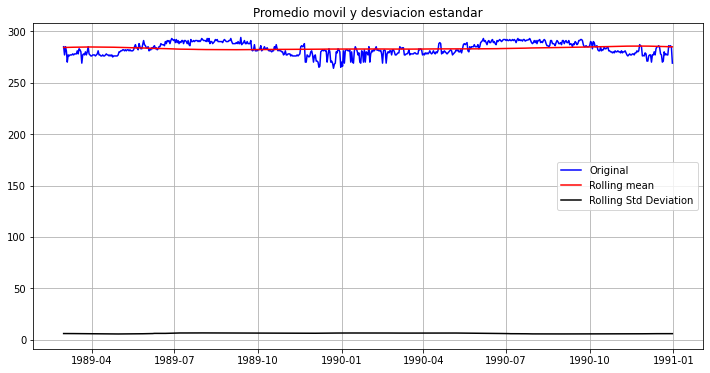

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                  -1.976033
p-Value                          0.297179
#Lags used                      10.000000
Number of observations used    660.000000
Critical Value(1%)              -3.440297
Critical Value(5%)              -2.865929
Critical Value(10%)             -2.569107
dtype: float64


In [115]:
df_90['TminK']=df_90['Tmin']+273.15
 
df_90.head()
ts_90=df_90.loc[startm:endm].copy()
#End es en 1999
ts_test_m=ts_90['TminK'].copy()
#print(ts_90.head())
ts_test_m.head()
test_stationarity(ts_test_m)

No usamos el mismo intervalo que para Tmax ya que en la Tmin en Junio de 1988 hay un hueco.
Ademas, vemos que no es estacionaria, asi que trabajaremos primero con la tendencia. 


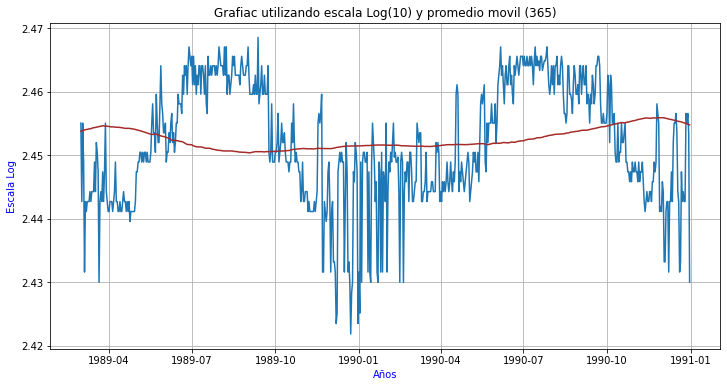

In [116]:
#Usare la funcion logaritmo base 10 
ts_test_m_log=np.log10(ts_test_m)
moving_avg_m=ts_test_m_log.rolling(365,center=True,min_periods=1).mean()

plt.plot(ts_test_m_log)
plt.plot(moving_avg_m,color='brown')

plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Grafiac utilizando escala Log(10) y promedio movil (365)')
plt.grid()
plt.show();





In [117]:
ts_test_m_log_moving_avg_diff = ts_test_m_log - moving_avg_m
ts_test_m_log_moving_avg_diff.head()

ts_test_m_log_moving_avg_diff.dropna(inplace=True)
ts_test_m_log_moving_avg_diff.tail()

Fecha
1990-12-27    0.001574
1990-12-28    0.000110
1990-12-29    0.001688
1990-12-30   -0.001300
1990-12-31   -0.024802
Name: TminK, dtype: float64

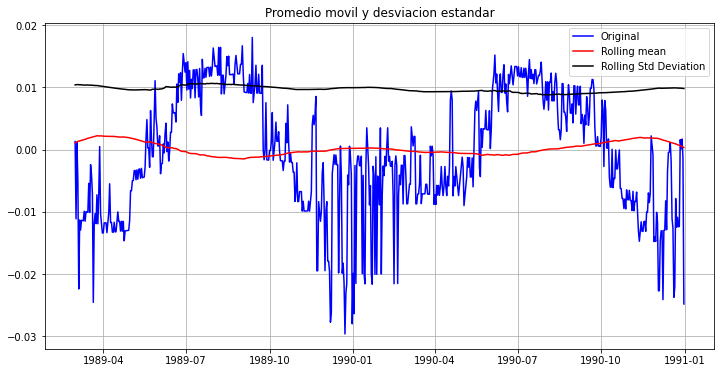

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                  -1.880651
p-Value                          0.341217
#Lags used                      10.000000
Number of observations used    660.000000
Critical Value(1%)              -3.440297
Critical Value(5%)              -2.865929
Critical Value(10%)             -2.569107
dtype: float64


In [118]:
#Probando la estacionaridad
test_stationarity(ts_test_m_log_moving_avg_diff)

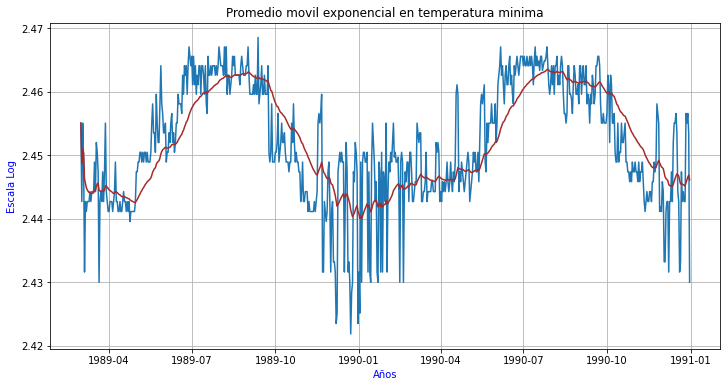

In [119]:
#Usando promedio moviles exponenciales

EWM_avg_m=ts_test_m_log.ewm(halflife=15).mean()
plt.plot(ts_test_m_log)
plt.plot(EWM_avg_m,color='brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio movil exponencial en temperatura minima')
plt.grid()
plt.show();

In [120]:
EWM_avg_m.head()

Fecha
1989-03-01    2.455073
1989-03-02    2.448751
1989-03-03    2.450957
1989-03-04    2.450417
1989-03-05    2.446299
Name: TminK, dtype: float64

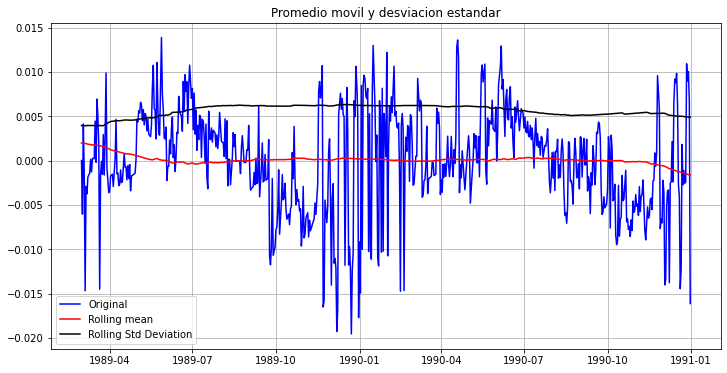

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                  -4.106171
p-Value                          0.000946
#Lags used                      10.000000
Number of observations used    660.000000
Critical Value(1%)              -3.440297
Critical Value(5%)              -2.865929
Critical Value(10%)             -2.569107
dtype: float64


In [121]:
ts_test_m_log_EWM_avg_diff = ts_test_m_log - EWM_avg_m
ts_test_m_log_EWM_avg_diff.dropna(inplace=True)
test_stationarity(ts_test_m_log_EWM_avg_diff)

Ahora trabajamos la estacionalidad


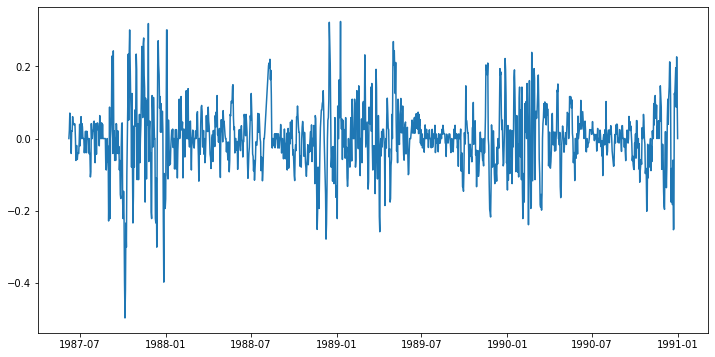

In [122]:
#Diferenciamos usando la funcion df.shift()
ts_test_m_log_diff = ts_test_m_log - ts_test_m_log.shift(periods=7)
plt.plot(ts_test_log_diff);

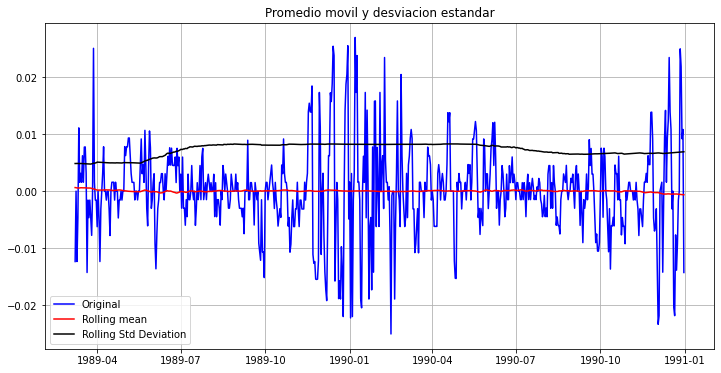

Los resultados de la prueba de Dickey-Fuller: 
Test Stadistic                -7.832174e+00
p-Value                        6.250668e-12
#Lags used                     2.000000e+01
Number of observations used    6.430000e+02
Critical Value(1%)            -3.440561e+00
Critical Value(5%)            -2.866045e+00
Critical Value(10%)           -2.569169e+00
dtype: float64


In [123]:
ts_test_m_log_diff.dropna(inplace=True)
test_stationarity(ts_test_m_log_diff)

In [124]:
len(ts_test_m_log_diff)

664

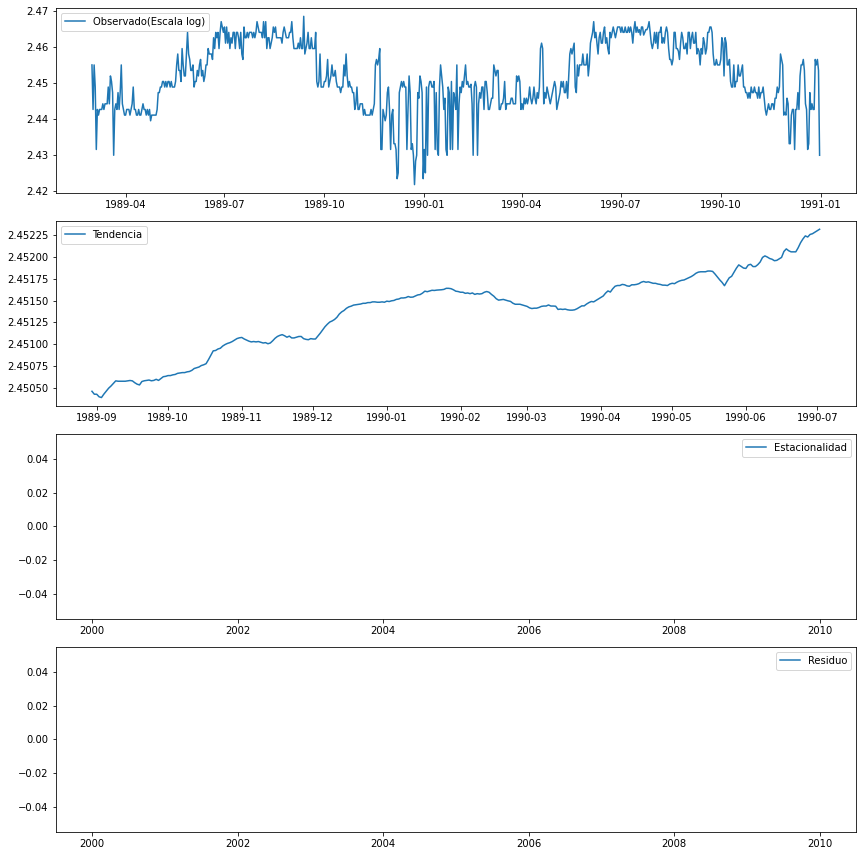

In [137]:
#Metodo de descomposicion usando la biblioteca statsmodels.tsa
decom_m=sm.tsa.seasonal_decompose(ts_test_m_log.interpolate(),model='additive',
                                  freq=365)
trendvv=decom_m.trend
seasonalvv = decom_m.seasonal
residuevv = decom_m.resid

plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_m_log,label='Observado(Escala log)')
plt.legend(loc='best')


plt.subplot(412)
plt.plot(trendvv,label='Tendencia')
plt.legend(loc='best')


plt.subplot(413)
plt.plot(seasonalvv,label='Estacionalidad')
plt.legend(loc='best')
#plt.xlim('1989-01','1991-12')


plt.subplot(414)
plt.plot(residuevv,label='Residuo')
plt.legend(loc='best')
#plt.xlim('1989-01','1991-12')



plt.tight_layout();
